In [1]:
import numpy as np
import torch
import sys
sys.path.append("../Generic scripts")
import matplotlib.pyplot as plt
import matplotlib as mpl
import utils_kernels as KT 
import utils_quantile as utils
import data_generator as generator

In [2]:
torch.set_default_dtype(torch.float64)
pt_path = "Experiments/tensors/"
fig_path = "Experiments/figures/"
csv_pat = "Experiments/tables/"

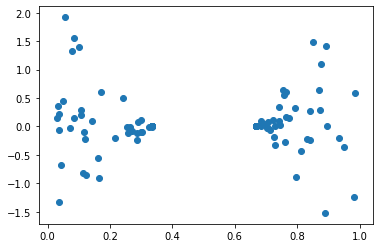

In [3]:
# Number of data points we will be using and basic parameters of the model
ndata = 100
# data generator : toy example of smola et al
mu_ex= generator.mu_ex
#sigma_ex = utils.sigma_ex
mu_ex = lambda x : 0*x
#def sigma_ex(x):
#    return 1*((x>0.5)).double() 
#sigma_ex = lambda x : 4*(x-0.5).clamp(min = 0)
sigma_ex = lambda x : 4*(x-2/3).clamp(min = 0) -  4*(x-1/3).clamp(max = 0)
xsample = 'weird3'
#xsample = 'hole_center'
xsample = 'doubleweird'

nbumps = 2
#r = 0.03
r = 0.1

colors = ['y','b','orange']

_,_,density = generator.doubleGenerator(mu_ex,sigma_ex,1,xsample=xsample,nbumps = nbumps,r=r,plot = False)


def gen(n = ndata):
    x,y,_ = generator.doubleGenerator(mu_ex,sigma_ex,ndata,xsample=xsample,nbumps = nbumps,r=r,plot = False)
    return (x,y)

data_set = gen()
xdata_path = pt_path + 'xdataExperiments.pt'
ydata_path = pt_path + 'ydataExperiments.pt'

torch.save(data_set[0],xdata_path)
torch.save(data_set[1],ydata_path)
plt.scatter(data_set[0],data_set[1])
plt.show()


def data_split(data_set,r=0.5):
    x,y = data_set
    n = x.size(0)
    l = np.array(range(n))
    np.random.shuffle(l)
    x,y = x[l,:],y[l]
    ntr = int(np.ceil(n*r))
    nts = n - ntr
    data_set_train = x[:ntr,:],y[:ntr]
    data_set_test =x[ntr:,:],y[ntr:]
    return data_set_train,data_set_test



#number of quantiles and quantile list 
Tm = 1
tau_l = list(np.linspace(0,1,2*Tm+3))[1:2*Tm+2]
T = len(tau_l)


# real thing

def real_quantiles(xp):
    return generator.get_quantiles_HS(mu_ex,sigma_ex,xp,tau_l)
    
#Loss function 

    

def LossQ(rx,ntest = 100):
    #Computes the KL(p(y|x)|| tp(y|x))
    xtest,ytest = gen(n=ntest)
    L = utils.QlossNW(ytest,tau_l).L
    Lb = lambda al : L(al)/ntest
    rxe =  rx(xtest)
    return Lb(rxe)







# Nadaraya Watson

In [31]:
def makerx(data_set,lae,lal,sigmae = 0.1,sigmal = 0.1,c=0,Niter = 10000,show_plot = False):
    x,y = data_set
    ym = y.mean()
    yr = y-ym
    
    
    eps = 0.01
    loss = utils.QlossNW(yr,tau_l)
    
    
    LMM = utils.kernelModel(sigmae,x,kernel = 'gaussian',c = c)
    LMD = utils.kernelModel(sigmal,x,kernel = 'gaussian',positive = True,c=c)
    model = utils.QLinearModelNW(LMM,LMD,T)
    
    hsm = utils.QModelNW(loss,lae,lal,model)
    
    freq = Niter // 10
    al = hsm.FISTA(Niter,freq = freq)
    
    def rx(x):
        return model.Rx(al,x) + ym
    return rx

## Choice of $\lambda$

lambda_e = 0.1, lambda_l = 0.1
lambda_e = 0.1, lambda_l = 0.1
lambda_e = 0.1, lambda_l = 0.1
lambda_e = 0.1, lambda_l = 0.1
lambda_e = 0.1, lambda_l = 0.1
lambda_e = 0.1, lambda_l = 0.01
lambda_e = 0.1, lambda_l = 0.01
lambda_e = 0.1, lambda_l = 0.01
lambda_e = 0.1, lambda_l = 0.01
lambda_e = 0.1, lambda_l = 0.01
lambda_e = 0.1, lambda_l = 0.001
lambda_e = 0.1, lambda_l = 0.001
lambda_e = 0.1, lambda_l = 0.001
lambda_e = 0.1, lambda_l = 0.001
lambda_e = 0.1, lambda_l = 0.001
lambda_e = 0.1, lambda_l = 0.0001
lambda_e = 0.1, lambda_l = 0.0001
lambda_e = 0.1, lambda_l = 0.0001
lambda_e = 0.1, lambda_l = 0.0001
lambda_e = 0.1, lambda_l = 0.0001
lambda_e = 0.01, lambda_l = 0.1
lambda_e = 0.01, lambda_l = 0.1
lambda_e = 0.01, lambda_l = 0.1
lambda_e = 0.01, lambda_l = 0.1
lambda_e = 0.01, lambda_l = 0.1
lambda_e = 0.01, lambda_l = 0.01
lambda_e = 0.01, lambda_l = 0.01
lambda_e = 0.01, lambda_l = 0.01
lambda_e = 0.01, lambda_l = 0.01
lambda_e = 0.01, lambda_l = 0.01
lambda_e = 0.01, lambda_l

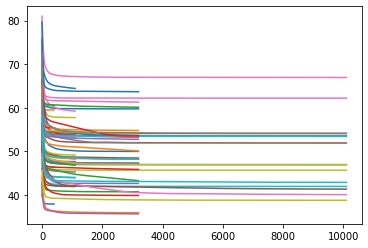

In [38]:
lae_l = [0.1,0.01,0.001]
lal_l = [0.1,0.01,0.001,0.0001]
la_l = []
for lae in lae_l:
    for lal in lal_l:
        #if lal/lae < 10.1 and lae/lal  < 10.1:
        la_l.append((lae,lal))
        

K = 5
res_list = []
for la in la_l:
    lae = la[0]
    lal = la[1]
    res = 0
    for k in range(K):
        data_set = gen()
        rx = makerx(data_set,lae,lal,Niter = 100+100*int(np.sqrt(1/min(lae,lal))))
        print('lambda_e = {}, lambda_l = {}'.format(lae,lal))
        res += LossQ(rx)
    res_list.append(res/K)

In [41]:
res_l = torch.zeros((3,len(la_l))) 
res_l[2,:] = torch.tensor(res_list)
res_l[0,:] = torch.tensor([v[0] for v in la_l])
res_l[1,:] = torch.tensor([v[1] for v in la_l])
torch.save(res_l,'lambda_choice_NW0.pt')

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.0100, 0.0100, 0.0100, 0.0100, 0.0010,
        0.0010, 0.0010, 0.0010])
tensor([0.1000, 0.0100, 0.0010, 0.0001, 0.1000, 0.0100, 0.0010, 0.0001, 0.1000,
        0.0100, 0.0010, 0.0001])


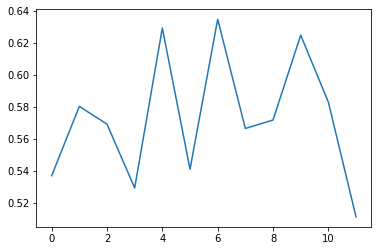

In [42]:
res_l = torch.load('lambda_choice_NW0.pt')
n = res_l.size(1)

print(res_l[0,:])
print(res_l[1,:])


plt.figure()
plt.plot(list(range(n)),res_l[2,:])
plt.show()

## Run

iteration 1 out of 3000
iteration 301 out of 3000
iteration 601 out of 3000
iteration 901 out of 3000
iteration 1201 out of 3000
iteration 1501 out of 3000
iteration 1801 out of 3000
iteration 2101 out of 3000
iteration 2401 out of 3000
iteration 2701 out of 3000


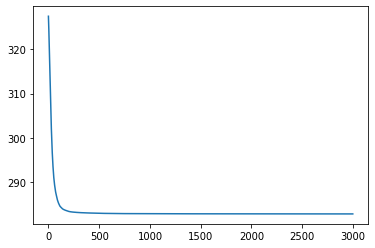

In [32]:
xdata = torch.load('xdataExperiments.pt')
ydata = torch.load('ydataExperiments.pt')
data_set = xdata,ydata
lae = 0.001
lal = 0.0001
rx = makerx(data_set,lae,lal,show_plot = True,Niter = 3000)




In [33]:
#Error
print(LossQ(rx))

tensor(2.8493)


In [34]:
xtest = torch.linspace(0,1,250)


ftau_train = rx(xtest)
ftau_real = real_quantiles(xtest)

xdata = data_set[0]
ydata = data_set[1]

torch.save(xtest,'xtestNW1.pt')

torch.save(ftau_train,'ftau_train_NW1.pt')
torch.save(ftau_real,'ftau_real_NW1.pt')

torch.save(xdata,'xdata_NW1.pt')
torch.save(ydata,'ydata_NW1.pt')





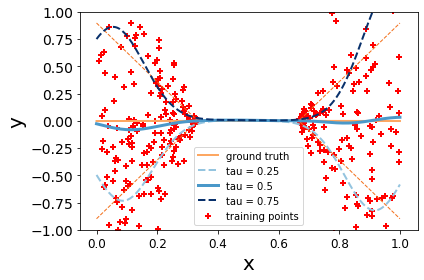

In [154]:
xtest = torch.load('xtestNW1.pt')

ftau_train = torch.load('ftau_train_NW1.pt')
ftau_real = torch.load('ftau_real_NW1.pt')

xdata = torch.load('xdata_NW1.pt')
ydata = torch.load('ydata_NW1.pt')


c = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
lc = [3,4,6]

ct = np.arange(1, 7)
normt = mpl.colors.Normalize(vmin=ct.min(), vmax=ct.max())
cmapt = mpl.cm.ScalarMappable(norm=normt, cmap=mpl.cm.Oranges)
cmapt.set_array([])
lct = [2,4,5]

lslist = ['dashed','solid','dashed']

fig = plt.figure()

for t in range(T):
    #c = colors[t]
    if t == (T-1)//2:
        lw = 2
        plt.plot(xtest,ftau_real[t,:],c=cmapt.to_rgba(3) ,lw = lw,linestyle = lslist[t] ,label = "ground truth")
    else:
        lw = 1
        plt.plot(xtest,ftau_real[t,:],c=cmapt.to_rgba(4) ,lw = lw,linestyle = lslist[t] )
for t in range(T):
    #c = colors[t]
    if t == (T-1)//2:
        lw = 3
    else:
        lw = 2
    plt.plot(xtest,ftau_train[t,:],c=cmap.to_rgba(lc[t]) ,lw = lw,linestyle = lslist[t], label = "tau = {}".format(tau_l[t]))
    

plt.scatter(xdata,ydata,marker = '+',color = 'r',lw = lw,label = 'training points')

plt.legend()
plt.ylim(-1,1)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
fig.savefig('NWPlot1quantile.pdf' , format='pdf', dpi=1000)
plt.show()    



# Our method 

In [4]:
def makerx(data_set,lam,lad,sigmam = 0.1,sigmad = 0.1,c=0,Niter = 300):
    x,y = data_set
    my = y.median()
    yr = y-my
    
    


    err = 0.01
  
    LMM = utils.QKM(sigmam,x,lam*err,mu = lam,kernel = 'gaussian',centered = False,c = c,positive = False)
    LMD = utils.QKM(sigmad,x,lad*err,mu = lad,kernel = 'gaussian',centered = False,c = c,positive = True)
    
    lmodel = utils.quantileLinearModel(T,LMM,LMD)
    
    qm = utils.quantileModel(lmodel,yr,tau_l)
    
    al = qm.prox_method(Niter,freq = Niter //10)
    
    def rx(x):
        return qm.Rx_dual(al,x) + my
    return rx

## Choice of $\lambda$

lambda_e = 1, lambda_l = 1
lambda_e = 1, lambda_l = 1
lambda_e = 1, lambda_l = 0.1
lambda_e = 1, lambda_l = 0.1
lambda_e = 1, lambda_l = 0.01
lambda_e = 1, lambda_l = 0.01
lambda_e = 1, lambda_l = 0.001
lambda_e = 1, lambda_l = 0.001
lambda_e = 0.1, lambda_l = 1
lambda_e = 0.1, lambda_l = 1
lambda_e = 0.1, lambda_l = 0.1
lambda_e = 0.1, lambda_l = 0.1
lambda_e = 0.1, lambda_l = 0.01
lambda_e = 0.1, lambda_l = 0.01
lambda_e = 0.1, lambda_l = 0.001
lambda_e = 0.1, lambda_l = 0.001
lambda_e = 0.01, lambda_l = 1
lambda_e = 0.01, lambda_l = 1
lambda_e = 0.01, lambda_l = 0.1
lambda_e = 0.01, lambda_l = 0.1
lambda_e = 0.01, lambda_l = 0.01
lambda_e = 0.01, lambda_l = 0.01
lambda_e = 0.01, lambda_l = 0.001
lambda_e = 0.01, lambda_l = 0.001


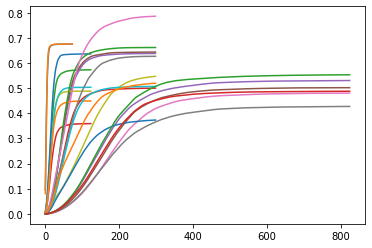

In [50]:
lae_l = [0.1,0.01,0.001,0.0001]
lal_l = [0.1,0.01,0.001,0.0001]
sigmae_l = [0.2,0.3,0.4,0.5]
sigmal_l = [0.2,0.3,0.4,0.5]

param_l = []
for lae in lae_l:
    for lal in lal_l:
        if lae/lal < 10.1 and lal/lae < 10.1:
            for sigmae in sigmae_l:
                for sigmal in sigmal_l:
                    param_l.append((lae,lal,sigmae,sigmal))
        

NN = len(param_l)

res = torch.zeros((6,NN))
res[2:,:] = torch.tensor(param_l).T

r = 0.7
K = 7

data_set = torch.load(xdata_path),torch.load(ydata_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        lae,lal,sigmae,sigmal = res[2,i],res[3,i],res[4,i],res[5,i]
        rx = makerx(data_set_train,lae,lal,sigmae = sigmae,sigmal = sigmal,Niter = 25 + 15*int(np.sqrt(1/min(lae,lal))))
        print('lambda_e = {}, lambda_l = {}, sigmae = {},sigmal = {}'.format(lae,lal,sigmae,sigmal))
        ll = LossHS(rx,data_set_test =data_set_test)
        print("ll = {}".format(ll))
        res[0,i] += ll
        res[1,i] += ll**2
    res[0,i]/= K
    res[1,i] /= K
    res[1,i] -= res[0,i]**2
    

In [53]:
#torch.save(res,pt_path + 'lambda_choice_linear1.pt')

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.0100,
        0.0100, 0.0100, 0.0100])
tensor([1.0000, 0.1000, 0.0100, 0.0010, 1.0000, 0.1000, 0.0100, 0.0010, 1.0000,
        0.1000, 0.0100, 0.0010])


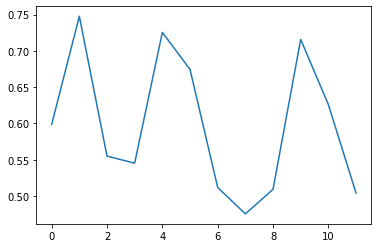

In [54]:
res_l = torch.load(pt_path +'lambda_choice_linear0.pt')
n = res_l.size(1)
#_,i = torch.sort(res_l[0,:])
#res_l = res_l[:,i]


print("lae")
print(res_l[2,:])
print("lal")
print(res_l[3,:])
print("sigmae")
print(res_l[4,:])
print("sigmal")
print(res_l[5,:])
print("result")
print(res_l[0,:])
print("ecart type")
print(torch.sqrt(res_l[1,:]))


plt.figure()
plt.plot(list(range(n)),res_l[0,:])
#plt.xlim(30,40)
plt.show()



## Run

tensor(1.)
tensor(1.)
iteration 1 out of 3150
iteration 316 out of 3150
iteration 631 out of 3150
iteration 946 out of 3150
iteration 1261 out of 3150
iteration 1576 out of 3150
iteration 1891 out of 3150
iteration 2206 out of 3150
iteration 2521 out of 3150
iteration 2836 out of 3150


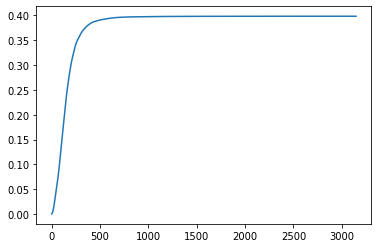

In [9]:
data_set = torch.load(xdata_path),torch.load(ydata_path)
lam = 0.1
lad = 0.001
rx = makerx(data_set,lam,lad,sigmam = 0.1,sigmad=0.1,Niter = 50+100*int(np.sqrt(1/min(lam,lad))))



In [10]:
#Plots

c,r,ntest = 0.5,0.5,1000
xtest = torch.linspace(c-r,c+r,ntest)
#c,r,ntest = 0,10,100000
#xtest = c + r*(2*torch.rand(ntest,d) - 1)
#xtest,_ = xtest.sort(dim=0)



ftau_train = rx(xtest)
ftau_real = real_quantiles(xtest)

xdata = data_set[0]
ydata = data_set[1]

torch.save(xtest,pt_path+'xtestours1.pt')

torch.save(ftau_train,pt_path+'ftau_train_ours1.pt')
torch.save(ftau_real,pt_path+'ftau_real_ours1.pt')

torch.save(xdata,pt_path+'xdata_ours1.pt')
torch.save(ydata,pt_path+'ydata_ours1.pt')

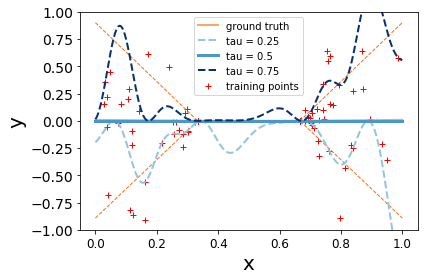

In [11]:
xtest = torch.load(pt_path+'xtestours1.pt')

ftau_train = torch.load(pt_path+'ftau_train_ours1.pt')
ftau_real = torch.load(pt_path+'ftau_real_ours1.pt')

xdata = torch.load(pt_path+'xdata_ours1.pt')
ydata = torch.load(pt_path+'ydata_ours1.pt')


c = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
lc = [3,4,6]

ct = np.arange(1, 7)
normt = mpl.colors.Normalize(vmin=ct.min(), vmax=ct.max())
cmapt = mpl.cm.ScalarMappable(norm=normt, cmap=mpl.cm.Oranges)
cmapt.set_array([])
lct = [2,4,5]

lslist = ['dashed','solid','dashed']

fig = plt.figure()

for t in range(T):
    #c = colors[t]
    if t == (T-1)//2:
        lw = 2
        plt.plot(xtest,ftau_real[t,:],c=cmapt.to_rgba(3) ,lw = lw,linestyle = lslist[t] ,label = "ground truth")
    else:
        lw = 1
        plt.plot(xtest,ftau_real[t,:],c=cmapt.to_rgba(4) ,lw = lw,linestyle = lslist[t] )
for t in range(T):
    #c = colors[t]
    if t == (T-1)//2:
        lw = 3
    else:
        lw = 2
    plt.plot(xtest,ftau_train[t,:],c=cmap.to_rgba(lc[t]) ,lw = lw,linestyle = lslist[t], label = "tau = {}".format(tau_l[t]))
 
plt.scatter(xdata,ydata,marker = '+',color = 'r',lw = 1,label = 'training points')
#plt.ylim(1,2.5)
plt.legend()
plt.ylim(-1,1)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
#fig.savefig(fig_path+'oursPlot1quantile.pdf' , format='pdf', dpi=1000)
plt.show()  

# linear model 

In [4]:
def makerx(data_set,lam,lad,sigmam = 0.1,sigmad = 0.1,c=10,Niter = 200):
    x,y = data_set
    my = y.median()
    yr = y-my
    
    
    LMM = utils.LMK(sigmam,x,lam,kernel = 'gaussian',centered = False,c = c,positive = False)
    LMD = utils.LMK(sigmad,x,lad,kernel = 'gaussian',centered = False,c = c,positive = True)
    

    
    lmodel = utils.quantileLinearModel(T,LMM,LMD)

    qm = utils.quantileModel(lmodel,y,tau_l)
    
    al = qm.prox_method(Niter,freq = Niter//10)
    
    def rx(x):
        return qm.Rx_dual(al,x) + my
    return rx

## Choice of $\lambda$

In [5]:
lae_l = [0.1,0.01,0.001,0.0001]
lal_l = [0.1,0.01,0.001,0.0001]
sigmae_l = [0.2,0.3,0.4,0.5]
sigmal_l = [0.2,0.3,0.4,0.5]

param_l = []
for lae in lae_l:
    for lal in lal_l:
        if lae/lal < 10.1 and lal/lae < 10.1:
            for sigmae in sigmae_l:
                for sigmal in sigmal_l:
                    param_l.append((lae,lal,sigmae,sigmal))
        

NN = len(param_l)

res = torch.zeros((6,NN))
res[2:,:] = torch.tensor(param_l).T

r = 0.7
K = 7

data_set = torch.load(xdata_path),torch.load(ydata_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        lae,lal,sigmae,sigmal = res[2,i],res[3,i],res[4,i],res[5,i]
        rx = makerx(data_set_train,lae,lal,sigmae = sigmae,sigmal = sigmal,Niter = 25 + 15*int(np.sqrt(1/min(lae,lal))))
        print('lambda_e = {}, lambda_l = {}, sigmae = {},sigmal = {}'.format(lae,lal,sigmae,sigmal))
        ll = LossHS(rx,data_set_test =data_set_test)
        print("ll = {}".format(ll))
        res[0,i] += ll
        res[1,i] += ll**2
    res[0,i]/= K
    res[1,i] /= K
    res[1,i] -= res[0,i]**2
    
    
    

TypeError: makerx() got an unexpected keyword argument 'sigmae'

In [6]:
#torch.save(res,pt_path + 'lambda_choice_linear1.pt')

In [27]:
res_l = torch.load(pt_path +'lambda_choice_linear0.pt')
n = res_l.size(1)
#_,i = torch.sort(res_l[0,:])
#res_l = res_l[:,i]


print("lae")
print(res_l[2,:])
print("lal")
print(res_l[3,:])
print("sigmae")
print(res_l[4,:])
print("sigmal")
print(res_l[5,:])
print("result")
print(res_l[0,:])
print("ecart type")
print(torch.sqrt(res_l[1,:]))


plt.figure()
plt.plot(list(range(n)),res_l[0,:])
#plt.xlim(30,40)
plt.show()



## Run

iteration 1 out of 3000
iteration 301 out of 3000
iteration 601 out of 3000
iteration 901 out of 3000
iteration 1201 out of 3000
iteration 1501 out of 3000
iteration 1801 out of 3000
iteration 2101 out of 3000
iteration 2401 out of 3000
iteration 2701 out of 3000


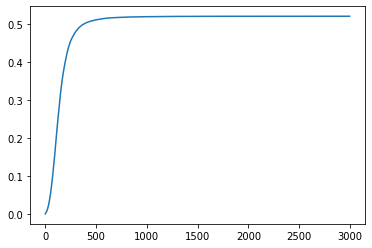

In [12]:
data_set = torch.load(xdata_path),torch.load(ydata_path)
lam = 0.01
lad = 0.001
rx = makerx(data_set,lam,lad,sigmam = 0.1,sigmad=0.1,Niter= 3000)


In [13]:
#Plots

c,r,ntest = 0.5,0.5,1000
xtest = torch.linspace(c-r,c+r,ntest)
#c,r,ntest = 0,10,100000
#xtest = c + r*(2*torch.rand(ntest,d) - 1)
#xtest,_ = xtest.sort(dim=0)



ftau_train = rx(xtest)
ftau_real = real_quantiles(xtest)

xdata = data_set[0]
ydata = data_set[1]

torch.save(xtest,pt_path+'xtestlinear1.pt')

torch.save(ftau_train,pt_path+'ftau_train_linear1.pt')
torch.save(ftau_real,pt_path+'ftau_real_linear1.pt')

torch.save(xdata,pt_path+'xdata_linear1.pt')
torch.save(ydata,pt_path+'ydata_linear1.pt')

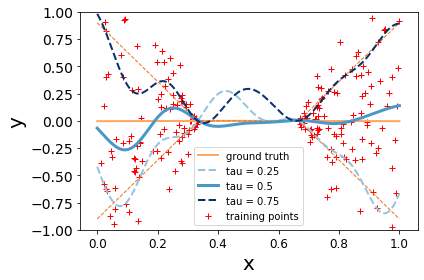

In [14]:
xtest = torch.load(pt_path+'xtestlinear1.pt')

ftau_train = torch.load(pt_path+'ftau_train_linear1.pt')
ftau_real = torch.load(pt_path+'ftau_real_linear1.pt')

xdata = torch.load(pt_path+'xdata_linear1.pt')
ydata = torch.load(pt_path+'ydata_linear1.pt')


c = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
lc = [3,4,6]

ct = np.arange(1, 7)
normt = mpl.colors.Normalize(vmin=ct.min(), vmax=ct.max())
cmapt = mpl.cm.ScalarMappable(norm=normt, cmap=mpl.cm.Oranges)
cmapt.set_array([])
lct = [2,4,5]

lslist = ['dashed','solid','dashed']

fig = plt.figure()

for t in range(T):
    #c = colors[t]
    if t == (T-1)//2:
        lw = 2
        plt.plot(xtest,ftau_real[t,:],c=cmapt.to_rgba(3) ,lw = lw,linestyle = lslist[t] ,label = "ground truth")
    else:
        lw = 1
        plt.plot(xtest,ftau_real[t,:],c=cmapt.to_rgba(4) ,lw = lw,linestyle = lslist[t] )
for t in range(T):
    #c = colors[t]
    if t == (T-1)//2:
        lw = 3
    else:
        lw = 2
    plt.plot(xtest,ftau_train[t,:],c=cmap.to_rgba(lc[t]) ,lw = lw,linestyle = lslist[t], label = "tau = {}".format(tau_l[t]))
 
plt.scatter(xdata,ydata,marker = '+',color = 'r',lw = 1,label = 'training points')
#plt.ylim(1,2.5)
plt.legend()
plt.ylim(-1,1)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
#fig.savefig(fig_path+'linearPlot1quantile.pdf' , format='pdf', dpi=1000)
plt.show()  

# GLM 

In [119]:
def makerx(data_set,lam,lad,sigmae = 0.4,sigmal = 0.2,c=0,Niter = 1000,show_plot = False):
    x,y = data_set
    ym = y.mean()
    yr = y-ym
    
    
    eps = 0.01
    loss = utils.QlossNW(yr,tau_l)
    
    
    LMM = utils.kernelModelExpo(sigmae,x,kernel = 'gaussian',c = c,positive = False)
    LMD = utils.kernelModelExpo(sigmal,x,kernel = 'gaussian',positive = True,c=c)
    model = utils.QLinearModelKernelExpo(LMM,LMD,T)
    
    hsm = utils.QModelExpo(loss,lam,lad,model)
    
    al = hsm.GD(Niter,freq = Niter//10)
    
    def rx(x):
        return model.px(al,x) + ym
    return rx

## Selecting $\lambda$

iteration 1 out of 40
iteration 5 out of 40
iteration 9 out of 40
iteration 13 out of 40
iteration 17 out of 40
iteration 21 out of 40
iteration 25 out of 40
iteration 29 out of 40
iteration 33 out of 40
iteration 37 out of 40
lambda_e = 0.1, lambda_l = 0.1
iteration 1 out of 40
iteration 5 out of 40
iteration 9 out of 40
iteration 13 out of 40
iteration 17 out of 40
iteration 21 out of 40
iteration 25 out of 40
iteration 29 out of 40
iteration 33 out of 40
iteration 37 out of 40
lambda_e = 0.1, lambda_l = 0.1
iteration 1 out of 40
iteration 5 out of 40
iteration 9 out of 40
iteration 13 out of 40
iteration 17 out of 40
iteration 21 out of 40
iteration 25 out of 40
iteration 29 out of 40
iteration 33 out of 40
iteration 37 out of 40
lambda_e = 0.1, lambda_l = 0.1
iteration 1 out of 40
iteration 5 out of 40
iteration 9 out of 40
iteration 13 out of 40
iteration 17 out of 40
iteration 21 out of 40
iteration 25 out of 40
iteration 29 out of 40
iteration 33 out of 40
iteration 37 out of 40

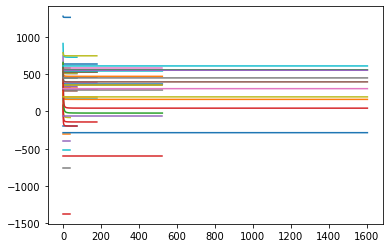

In [124]:
lae_l = [0.1]
lal_l = [0.1,0.01,0.001,0.0001,0.00001]
la_l = []
for lae in lae_l:
    for lal in lal_l:
        #if lal/lae < 10.1 and lae/lal  < 10.1:
        la_l.append((lae,lal))
        

K = 10
res_list = []
for la in la_l:
    lae = la[0]
    lal = la[1]
    res = 0
    for k in range(K):
        data_set = gen()
        rx = makerx(data_set,lae,lal,Niter = 25+5*int(np.sqrt(1/min(lae,lal))))
        print('lambda_e = {}, lambda_l = {}'.format(lae,lal))
        res = min(res,LossQ(rx))
    res_list.append(res)

In [125]:
res_l = torch.zeros((3,len(la_l))) 
res_l[2,:] = torch.tensor(res_list)
res_l[0,:] = torch.tensor([v[0] for v in la_l])
res_l[1,:] = torch.tensor([v[1] for v in la_l])
torch.save(res_l,'lambda_choice_GLM1.pt')

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000])
tensor([1.0000e-01, 1.0000e-02, 1.0000e-03, 1.0000e-04, 1.0000e-05])
[0, 0, 0, 0, 0]


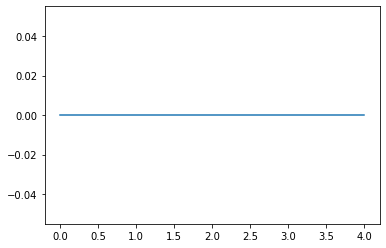

In [127]:
res_l = torch.load('lambda_choice_GLM1.pt')
n = res_l.size(1)

print(res_l[0,:])
print(res_l[1,:])

print(res_list)

plt.figure()
plt.plot(list(range(n)),res_l[2,:])
plt.show()

## Run

iteration 1 out of 1050
iteration 106 out of 1050
iteration 211 out of 1050
iteration 316 out of 1050
iteration 421 out of 1050
iteration 526 out of 1050
iteration 631 out of 1050
iteration 736 out of 1050
iteration 841 out of 1050
iteration 946 out of 1050


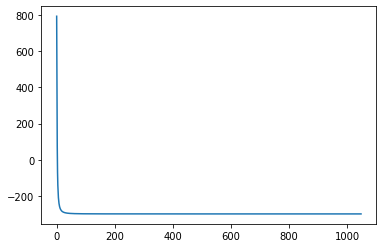

In [132]:
xdata = torch.load('xdataExperiments.pt')
ydata = torch.load('ydataExperiments.pt')
data_set = xdata,ydata
lae = 0.1
lal = 0.01
rx = makerx(data_set,lae,lal,show_plot = True,Niter = 50+100*int(np.sqrt(1/min(lae,lal))))





In [133]:
#Error
print(LossQ(rx))

tensor(4.0579)


In [134]:
xtest = torch.linspace(0,1,250)


ftau_train = rx(xtest)
ftau_real = real_quantiles(xtest)

xdata = data_set[0]
ydata = data_set[1]

torch.save(xtest,'xtestGLM1.pt')

torch.save(ftau_train,'ftau_train_GLM1.pt')
torch.save(ftau_real,'ftau_real_GLM1.pt')

torch.save(xdata,'xdata_GLM1.pt')
torch.save(ydata,'ydata_GLM1.pt')



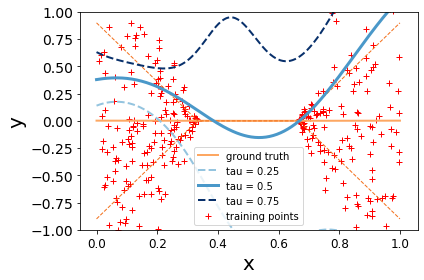

In [157]:
xtest = torch.load('xtestGLM1.pt')

ftau_train = torch.load('ftau_train_GLM1.pt')
ftau_real = torch.load('ftau_real_GLM1.pt')

xdata = torch.load('xdata_GLM1.pt')
ydata = torch.load('ydata_GLM1.pt')


c = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
lc = [3,4,6]

ct = np.arange(1, 7)
normt = mpl.colors.Normalize(vmin=ct.min(), vmax=ct.max())
cmapt = mpl.cm.ScalarMappable(norm=normt, cmap=mpl.cm.Oranges)
cmapt.set_array([])
lct = [2,4,5]

lslist = ['dashed','solid','dashed']

fig = plt.figure()

for t in range(T):
    #c = colors[t]
    if t == (T-1)//2:
        lw = 2
        plt.plot(xtest,ftau_real[t,:],c=cmapt.to_rgba(3) ,lw = lw,linestyle = lslist[t] ,label = "ground truth")
    else:
        lw = 1
        plt.plot(xtest,ftau_real[t,:],c=cmapt.to_rgba(4) ,lw = lw,linestyle = lslist[t] )
for t in range(T):
    #c = colors[t]
    if t == (T-1)//2:
        lw = 3
    else:
        lw = 2
    plt.plot(xtest,ftau_train[t,:],c=cmap.to_rgba(lc[t]) ,lw = lw,linestyle = lslist[t], label = "tau = {}".format(tau_l[t]))
 
plt.scatter(xdata,ydata,marker = '+',color = 'r',lw = 1,label = 'training points')

plt.legend()
plt.ylim(-1,1)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
fig.savefig('GLMPlot1quantile.pdf' , format='pdf', dpi=1000)
plt.show()    